In [17]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, random_split
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from sklearn.metrics import accuracy_score
from torchvision import datasets, transforms
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import RandomSampler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

In [18]:
# Data augmentation functions
def rotate_point_cloud(points):
    """Rotate the point cloud around the z-axis."""
    angle = np.random.uniform(0, 2 * np.pi)
    cos_val = np.cos(angle)
    sin_val = np.sin(angle)
    rotation_matrix = np.array([
        [cos_val, -sin_val, 0],
        [sin_val, cos_val, 0],
        [0, 0, 1]
    ])
    rotated_points = np.dot(points, rotation_matrix.T)
    return rotated_points

def translate_point_cloud(points):
    """Translate the point cloud by a small random vector."""
    translation_vector = np.random.uniform(-0.2, 0.2, size=(1, 3))
    translated_points = points + translation_vector
    return translated_points

def scale_point_cloud(points):
    """Scale the point cloud by a random factor."""
    scale_factor = np.random.uniform(0.8, 1.2)
    scaled_points = points * scale_factor
    return scaled_points

def jitter_point_cloud(points):
    """Add Gaussian noise to the point cloud."""
    noise = np.random.normal(0, 0.01, points.shape)
    jittered_points = points + noise
    return jittered_points

def augment_point_cloud(points):
    points = rotate_point_cloud(points)
    points = translate_point_cloud(points)
    points = scale_point_cloud(points)
    points = jitter_point_cloud(points)
    return points

In [19]:


def normalize_point_cloud(points):
    """Normalize the point cloud."""
    centroid = np.mean(points, axis=0)
    points -= centroid
    max_dist = np.max(np.sqrt(np.sum(points**2, axis=1)))
    points /= max_dist
    return points

class PointCloudDataset(Dataset):
    def __init__(self, data_dir, augment=False):
        self.data_dir = data_dir
        self.files = [f for f in os.listdir(data_dir) if f.endswith('.npy')]
        self.augment = augment

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.files[idx])
        data = np.load(file_path)
        points = data[:, :3]  
        labels = data[:, 3]   
        
        if self.augment:
            points = augment_point_cloud(points)
            
        
        points = normalize_point_cloud(points)
        
        
        points = torch.FloatTensor(points)
        labels = torch.FloatTensor(labels)  # Convert labels to float for BCELoss
        
        return points, labels



def collate_fn(batch):
 
    max_points = min(1024, max(item[0].size(0) for item in batch))  # Limit to 1024 points

    padded_points = []
    padded_labels = []

    for points, labels in batch:
        
        if points.size(0) > max_points:
            points = points[:max_points]
            labels = labels[:max_points]
        
        
        pad_size = max_points - points.size(0)
        
   
        padded = torch.nn.functional.pad(points, (0, 0, 0, pad_size)) 
        padded_points.append(padded)
        

        padded_label = torch.cat((labels, torch.zeros(pad_size)))
        padded_labels.append(padded_label)


    return torch.stack(padded_points), torch.stack(padded_labels)

In [20]:
import torch
import torch.nn as nn

class PointNetPlusPlus(nn.Module):
    def __init__(self):
        super(PointNetPlusPlus, self).__init__()

        # First MLP block with dropout
        self.mlp1 = nn.Sequential(
            nn.Linear(3, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self.bn1 = nn.BatchNorm1d(512)  

       
        self.residual1 = nn.Linear(3, 512) 

       
        self.abstraction = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )

        self.mlp2 = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  
        )

       
        self.residual2 = nn.Linear(128, 1) 

        self.mlp3 = nn.Sequential(
            nn.Linear(1, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1) 
        )
        
       
        self.residual3 = nn.Linear(1, 1)  

    def forward(self, x):
        # Apply the first MLP
        identity1 = self.residual1(x)
        x = self.mlp1(x)
        x = x + identity1

        # Apply the second MLP with residual connection
        x = self.abstraction(x)
        identity2 = self.residual2(x)
        x = self.mlp2(x)
        x = x + identity2

        # Apply the third MLP with residual connection
        identity3 = self.residual3(x)
        x = self.mlp3(x)
        x = x + identity3

        # Final output
        return x.squeeze(-1) 


In [21]:
import zipfile
import os

# Define the path to your zip file and the extraction directory
zip_file_path = '/home/jovyan/RnD/dataset_npy.zip'
extract_dir = '/home/jovyan/RnD/dataset_npy'  # Folder where data will be extracted

# Check if the extraction directory exists, if not, create it
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Extracted data to {extract_dir}")

Extracted data to /home/jovyan/RnD/dataset_npy


In [22]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import os
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

data_dir = '/home/jovyan/RnD/dataset_npy/dataset_csf' #provide input directory of the filtered data

# Hyperparameters
batch_size = 16
num_epochs = 100
learning_rate = 0.001
step_size = 20  
gamma = 0.7  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset and DataLoader
train_dataset = PointCloudDataset(data_dir=data_dir, augment=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

val_dataset = PointCloudDataset(data_dir=data_dir, augment=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Model
model = PointNetPlusPlus().to(device)


criterion = nn.BCEWithLogitsLoss()


optimizer = optim.Adam(model.parameters(), lr=learning_rate)


scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)


epoch_durations = []
train_losses = []


start_time = time.time()

# Training Loop
best_val_loss = float('inf')
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    for data, labels in tqdm(dataloader, desc="Training", leave=False):
        data = data.to(device).float()
        labels = labels.to(device).float()  # BCEWithLogitsLoss expects float

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss


def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, labels in tqdm(dataloader, desc="Validation", leave=False):
            data = data.to(device).float()
            labels = labels.to(device).float()

            outputs = model(data)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * data.size(0)

            # Compute accuracy (using threshold of 0.5 for BCE)
            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == labels.bool()).sum().item()
            total += labels.numel()

    epoch_loss = running_loss / len(dataloader.dataset)
    accuracy = correct / total if total > 0 else 0
    return epoch_loss, accuracy
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    
    
    epoch_start_time = time.time()
    
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)
    
    
    epoch_duration = time.time() - epoch_start_time
    epoch_durations.append(epoch_duration)
    train_losses.append(train_loss)
    
   
    scheduler.step()
    
    print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
    
    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'edgesegment_pointnet_model.pth')
        print('Saved the best model!')

print('Training finished!')


elapsed_times = [sum(epoch_durations[:i+1]) for i in range(num_epochs)] 
df = pd.DataFrame({
    'Elapsed Time (s)': elapsed_times,
    'Train Loss': train_losses
})
df.to_csv('training_time_vs_loss.csv', index=False)

# # Plot Training Loss vs Elapsed Time
# plt.figure(figsize=(10, 6))
# plt.plot(elapsed_times, train_losses, label='Training Loss')
# plt.xlabel('Elapsed Time (s)')
# plt.ylabel('Training Loss')
# plt.title('Training Loss vs Elapsed Time')
# plt.legend()
# plt.grid(True)
# plt.savefig('training_loss_vs_time.png')
# plt.show()


Epoch 1/100


Training:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.6172, Val Loss: 0.5619, Val Accuracy: 0.7494
Saved the best model!
Epoch 2/100


Train Loss: 0.5605, Val Loss: 0.5394, Val Accuracy: 0.7494
Saved the best model!
Epoch 3/100


Train Loss: 0.5201, Val Loss: 0.3732, Val Accuracy: 0.8535
Saved the best model!
Epoch 4/100


Train Loss: 0.4690, Val Loss: 0.3576, Val Accuracy: 0.8451
Saved the best model!
Epoch 5/100


Train Loss: 0.3805, Val Loss: 0.2871, Val Accuracy: 0.8832
Saved the best model!
Epoch 6/100


Train Loss: 0.2201, Val Loss: 0.0982, Val Accuracy: 0.9542
Saved the best model!
Epoch 7/100


Train Loss: 0.2099, Val Loss: 0.1440, Val Accuracy: 0.9586
Epoch 8/100


Train Loss: 0.1186, Val Loss: 0.0648, Val Accuracy: 0.9757
Saved the best model!
Epoch 9/100


Train Loss: 0.0776, Val Loss: 0.0869, Val Accuracy: 0.9616
Epoch 10/100


Train Loss: 0.0782, Val Loss: 0.1000, Val Accuracy: 0.9521
Epoch 11/100


Train Loss: 0.1032, Val Loss: 0.0710, Val Accuracy: 0.9728
Epoch 12/100


Train Loss: 0.0561, Val Loss: 0.0604, Val Accuracy: 0.9725
Saved the best model!
Epoch 13/100


Train Loss: 0.0804, Val Loss: 0.0567, Val Accuracy: 0.9777
Saved the best model!
Epoch 14/100


Train Loss: 0.0479, Val Loss: 0.0460, Val Accuracy: 0.9767
Saved the best model!
Epoch 15/100


Train Loss: 0.0788, Val Loss: 0.0867, Val Accuracy: 0.9532
Epoch 16/100


Train Loss: 0.0654, Val Loss: 0.0516, Val Accuracy: 0.9761
Epoch 17/100


Train Loss: 0.0394, Val Loss: 0.0245, Val Accuracy: 0.9918
Saved the best model!
Epoch 18/100


Train Loss: 0.0780, Val Loss: 0.0490, Val Accuracy: 0.9902
Epoch 19/100


Train Loss: 0.0426, Val Loss: 0.0292, Val Accuracy: 0.9911
Epoch 20/100


Train Loss: 0.0509, Val Loss: 0.0995, Val Accuracy: 0.9622
Epoch 21/100


Train Loss: 0.0662, Val Loss: 0.0447, Val Accuracy: 0.9863
Epoch 22/100


Train Loss: 0.0406, Val Loss: 0.0274, Val Accuracy: 0.9927
Epoch 23/100


Train Loss: 0.0309, Val Loss: 0.0261, Val Accuracy: 0.9889
Epoch 24/100


Train Loss: 0.0308, Val Loss: 0.0273, Val Accuracy: 0.9883
Epoch 25/100


Train Loss: 0.0352, Val Loss: 0.0272, Val Accuracy: 0.9891
Epoch 26/100


Train Loss: 0.0360, Val Loss: 0.0270, Val Accuracy: 0.9892
Epoch 27/100


Train Loss: 0.0351, Val Loss: 0.0318, Val Accuracy: 0.9861
Epoch 28/100


Train Loss: 0.0273, Val Loss: 0.0203, Val Accuracy: 0.9934
Saved the best model!
Epoch 29/100


Train Loss: 0.0302, Val Loss: 0.0255, Val Accuracy: 0.9888
Epoch 30/100


Train Loss: 0.0413, Val Loss: 0.0266, Val Accuracy: 0.9933
Epoch 31/100


Train Loss: 0.0298, Val Loss: 0.0304, Val Accuracy: 0.9846
Epoch 32/100


Train Loss: 0.0275, Val Loss: 0.0336, Val Accuracy: 0.9825
Epoch 33/100


Train Loss: 0.0465, Val Loss: 0.0456, Val Accuracy: 0.9797
Epoch 34/100


Train Loss: 0.0306, Val Loss: 0.0234, Val Accuracy: 0.9924
Epoch 35/100


Train Loss: 0.0244, Val Loss: 0.0228, Val Accuracy: 0.9910
Epoch 36/100


Train Loss: 0.0273, Val Loss: 0.0223, Val Accuracy: 0.9913
Epoch 37/100


Train Loss: 0.0348, Val Loss: 0.0320, Val Accuracy: 0.9832
Epoch 38/100


Train Loss: 0.0316, Val Loss: 0.0236, Val Accuracy: 0.9906
Epoch 39/100


Train Loss: 0.0315, Val Loss: 0.0248, Val Accuracy: 0.9907
Epoch 40/100


Train Loss: 0.0259, Val Loss: 0.0359, Val Accuracy: 0.9849
Epoch 41/100


Train Loss: 0.0265, Val Loss: 0.0266, Val Accuracy: 0.9865
Epoch 42/100


Train Loss: 0.0254, Val Loss: 0.0273, Val Accuracy: 0.9888
Epoch 43/100


Train Loss: 0.0333, Val Loss: 0.0261, Val Accuracy: 0.9872
Epoch 44/100


Train Loss: 0.0296, Val Loss: 0.0296, Val Accuracy: 0.9885
Epoch 45/100


Train Loss: 0.0250, Val Loss: 0.0205, Val Accuracy: 0.9930
Epoch 46/100


Train Loss: 0.0228, Val Loss: 0.0184, Val Accuracy: 0.9930
Saved the best model!
Epoch 47/100


Train Loss: 0.0224, Val Loss: 0.0334, Val Accuracy: 0.9829
Epoch 48/100


Train Loss: 0.0241, Val Loss: 0.0184, Val Accuracy: 0.9928
Epoch 49/100


Train Loss: 0.0265, Val Loss: 0.0289, Val Accuracy: 0.9846
Epoch 50/100


Train Loss: 0.0218, Val Loss: 0.0330, Val Accuracy: 0.9827
Epoch 51/100


Train Loss: 0.0239, Val Loss: 0.0270, Val Accuracy: 0.9892
Epoch 52/100


Train Loss: 0.0265, Val Loss: 0.0220, Val Accuracy: 0.9894
Epoch 53/100


Train Loss: 0.0215, Val Loss: 0.0215, Val Accuracy: 0.9895
Epoch 54/100


Train Loss: 0.0233, Val Loss: 0.0183, Val Accuracy: 0.9929
Saved the best model!
Epoch 55/100


Train Loss: 0.0245, Val Loss: 0.0403, Val Accuracy: 0.9784
Epoch 56/100


Train Loss: 0.0280, Val Loss: 0.0214, Val Accuracy: 0.9906
Epoch 57/100


Train Loss: 0.0219, Val Loss: 0.0206, Val Accuracy: 0.9906
Epoch 58/100


Train Loss: 0.0277, Val Loss: 0.0221, Val Accuracy: 0.9895
Epoch 59/100


Train Loss: 0.0241, Val Loss: 0.0413, Val Accuracy: 0.9846
Epoch 60/100


Train Loss: 0.0262, Val Loss: 0.0337, Val Accuracy: 0.9810
Epoch 61/100


Train Loss: 0.0217, Val Loss: 0.0187, Val Accuracy: 0.9929
Epoch 62/100


Train Loss: 0.0213, Val Loss: 0.0174, Val Accuracy: 0.9924
Saved the best model!
Epoch 63/100


Train Loss: 0.0223, Val Loss: 0.0182, Val Accuracy: 0.9929
Epoch 64/100


Train Loss: 0.0191, Val Loss: 0.0170, Val Accuracy: 0.9934
Saved the best model!
Epoch 65/100


Train Loss: 0.0238, Val Loss: 0.0226, Val Accuracy: 0.9913
Epoch 66/100


Train Loss: 0.0231, Val Loss: 0.0255, Val Accuracy: 0.9901
Epoch 67/100


Train Loss: 0.0217, Val Loss: 0.0182, Val Accuracy: 0.9918
Epoch 68/100


Train Loss: 0.0219, Val Loss: 0.0267, Val Accuracy: 0.9852
Epoch 69/100


Train Loss: 0.0205, Val Loss: 0.0190, Val Accuracy: 0.9927
Epoch 70/100


Train Loss: 0.0210, Val Loss: 0.0161, Val Accuracy: 0.9933
Saved the best model!
Epoch 71/100


Train Loss: 0.0205, Val Loss: 0.0192, Val Accuracy: 0.9927
Epoch 72/100


Train Loss: 0.0193, Val Loss: 0.0158, Val Accuracy: 0.9936
Saved the best model!
Epoch 73/100


Train Loss: 0.0221, Val Loss: 0.0187, Val Accuracy: 0.9909
Epoch 74/100


Train Loss: 0.0190, Val Loss: 0.0210, Val Accuracy: 0.9890
Epoch 75/100


Train Loss: 0.0211, Val Loss: 0.0193, Val Accuracy: 0.9901
Epoch 76/100


Train Loss: 0.0267, Val Loss: 0.0203, Val Accuracy: 0.9906
Epoch 77/100


Train Loss: 0.0238, Val Loss: 0.0253, Val Accuracy: 0.9901
Epoch 78/100


Train Loss: 0.0211, Val Loss: 0.0273, Val Accuracy: 0.9847
Epoch 79/100


Train Loss: 0.0252, Val Loss: 0.0182, Val Accuracy: 0.9933
Epoch 80/100


Train Loss: 0.0226, Val Loss: 0.0183, Val Accuracy: 0.9924
Epoch 81/100


Train Loss: 0.0239, Val Loss: 0.0254, Val Accuracy: 0.9900
Epoch 82/100


Train Loss: 0.0234, Val Loss: 0.0181, Val Accuracy: 0.9923
Epoch 83/100


Train Loss: 0.0190, Val Loss: 0.0199, Val Accuracy: 0.9897
Epoch 84/100


Train Loss: 0.0194, Val Loss: 0.0188, Val Accuracy: 0.9904
Epoch 85/100


Train Loss: 0.0199, Val Loss: 0.0194, Val Accuracy: 0.9926
Epoch 86/100


Train Loss: 0.0239, Val Loss: 0.0164, Val Accuracy: 0.9937
Epoch 87/100


Train Loss: 0.0210, Val Loss: 0.0176, Val Accuracy: 0.9924
Epoch 88/100


Train Loss: 0.0185, Val Loss: 0.0204, Val Accuracy: 0.9893
Epoch 89/100


Train Loss: 0.0189, Val Loss: 0.0221, Val Accuracy: 0.9884
Epoch 90/100


Train Loss: 0.0184, Val Loss: 0.0201, Val Accuracy: 0.9896
Epoch 91/100


Train Loss: 0.0246, Val Loss: 0.0260, Val Accuracy: 0.9899
Epoch 92/100


Train Loss: 0.0223, Val Loss: 0.0211, Val Accuracy: 0.9920
Epoch 93/100


Train Loss: 0.0220, Val Loss: 0.0196, Val Accuracy: 0.9927
Epoch 94/100


Train Loss: 0.0216, Val Loss: 0.0166, Val Accuracy: 0.9930
Epoch 95/100


Train Loss: 0.0224, Val Loss: 0.0194, Val Accuracy: 0.9903
Epoch 96/100


Train Loss: 0.0266, Val Loss: 0.0284, Val Accuracy: 0.9885
Epoch 97/100


Train Loss: 0.0233, Val Loss: 0.0179, Val Accuracy: 0.9935
Epoch 98/100


Train Loss: 0.0187, Val Loss: 0.0206, Val Accuracy: 0.9893
Epoch 99/100


Train Loss: 0.0202, Val Loss: 0.0161, Val Accuracy: 0.9936
Epoch 100/100


Train Loss: 0.0211, Val Loss: 0.0161, Val Accuracy: 0.9934
Training finished!


In [23]:
import torch
import numpy as np
from torch.utils.data import DataLoader


model.load_state_dict(torch.load('edgesegment_pointnet_model.pth', map_location=device))
model.to(device)
model.eval()  

# Load the test data
test_file = '/home/jovyan/RnD/dataset_npy/dataset_csf/chunk_49.npy' #provide appropriate test data location
test_data = np.load(test_file)
test_points = torch.tensor(test_data[:, :3], dtype=torch.float32) 
test_labels = torch.tensor(test_data[:, 3], dtype=torch.float32) 

# Prepare test data loader
test_dataset = torch.utils.data.TensorDataset(test_points, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Testing function
def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for points, labels in test_loader:
            points, labels = points.to(device), labels.to(device)
            
            outputs = model(points)
            outputs = outputs.squeeze(-1)  # Shape: [batch_size, num_points]
            
            predicted = torch.round(torch.sigmoid(outputs))  # Apply sigmoid and round to get [0, 1]
            correct += (predicted == labels).sum().item()
            total += labels.numel()
    
    accuracy = correct / total
    return accuracy

# Test the model
test_accuracy = test_model(model, test_loader, device)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


# dlrv_project_ws/test_pico_2024-07-04_215824.npy

/tmp/ipykernel_26101/3501453223.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('edgesegment_pointnet_model.pth', map_location=device))


Test Accuracy: 34.23%


/tmp/ipykernel_26101/1264956244.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('edgesegment_pointnet_model.pth')) #load the model usin

Model output shape: torch.Size([1, 2191])


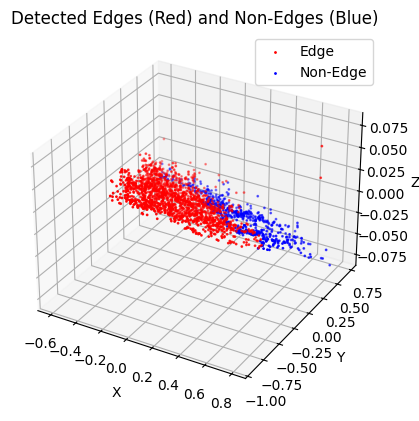

In [24]:
# Function to plot the point cloud with predicted edge and non-edge points
def plot_point_cloud_with_predictions(points, predictions):
    

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')


    if isinstance(predictions, torch.Tensor):
        predictions = predictions.cpu().numpy()


    if predictions.ndim == 1:
        predictions = predictions.reshape(-1)


    edges = points[predictions == 1]
    non_edges = points[predictions == 0]


    ax.scatter(edges[:, 0], edges[:, 1], edges[:, 2], c='r', label='Edge', s=1)


    ax.scatter(non_edges[:, 0], non_edges[:, 1], non_edges[:, 2], c='b', label='Non-Edge', s=1)


    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.legend()
    plt.title("Detected Edges (Red) and Non-Edges (Blue)")
    

    plt.show()

# provide Test point cloud file path
test_file = '/home/jovyan/RnD/dataset_npy/dataset_csf/chunk_49.npy'

# Load the test point cloud
data = np.load(test_file)
points = data[:, :3] 


points = normalize_point_cloud(points)


points_tensor = torch.FloatTensor(points).unsqueeze(0).to(device) 

model = PointNetPlusPlus().to(device)
model.load_state_dict(torch.load('edgesegment_pointnet_model.pth')) #load the model using correct path
with torch.no_grad():
    outputs = model(points_tensor)
    print(f"Model output shape: {outputs.shape}")
    

    if outputs.ndimension() == 3:  
        outputs = outputs.squeeze(-1)  

    predictions = torch.round(torch.sigmoid(outputs)).squeeze()  # [num_points]


if predictions.ndimension() == 1:
    predictions = predictions.cpu().numpy()
else:
    predictions = predictions.squeeze().cpu().numpy()


# Plot the point cloud with predicted edges and non-edges
plot_point_cloud_with_predictions(points, predictions)


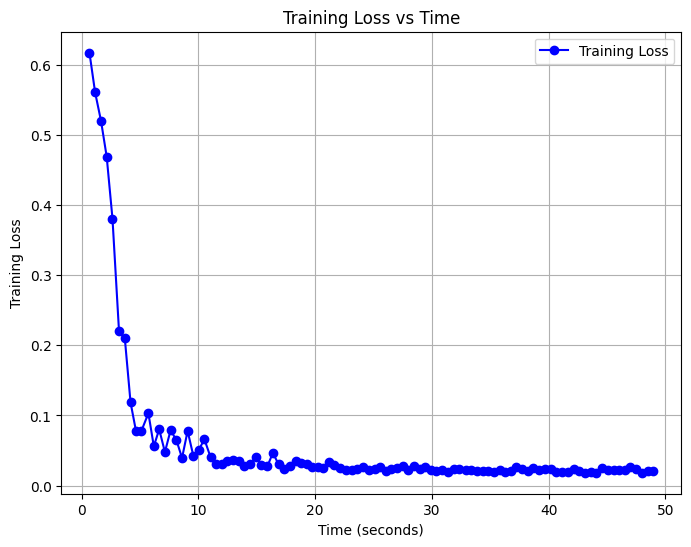

In [25]:

file_path= r'/home/jovyan/RnD/training_time_vs_loss.csv' #provide the correct filepath for the same
data = pd.read_csv(file_path)

# Plot training loss vs time
plt.figure(figsize=(8, 6))
plt.plot(data['Elapsed Time (s)'], data['Train Loss'], label='Training Loss', color='blue', marker='o')
plt.xlabel('Time (seconds)')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Time')
plt.legend()
plt.grid(True)
plt.show()